# Laboratory 05: Feeding NN's and Preparing Data

So far in the class we discussed feedforward neural networks which have been around since the late 1950s. These are the building blocks for the more advanced networks for Deep Learning. Recall that the networks are built from individual parts by approximating neurons, typically called units or simply "neurons." Each unit has some number of weighted inputs. These weighted inputs are summed together (a linear combination) then passed through an activation function to get the unit's output.

<img src="res/simple_neuron.png" width=400px>

Mathematically this looks like: 

$$
\begin{align}
\hat{y} &= f(w_1 x_1 + w_2 x_2 + b) \\
\hat{y} &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

With vectors this is the dot/inner product of two vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

In the first part of this lab you'll get the opportunity to implement this using what we have learned thus far about PyTorch, namely tensor operations. Moreover, in the second part you'll implement the ETL process in PyTorch for a new dataset called FashionMNIST. This we'll give you a better understanding of whats going on when we'll start using the full fledged PyTorch framework and will be essential for what will come next in the class.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Single Neuron Feedforward 

In this section we start with the implementation for a single neuron unit prediction using only tensor operations. In order to do this we need to generate some dummy data and initialize our weights and bias. PyTrorch includes a range of methods for generating random data that are described in the [documentation](https://pytorch.org/docs/stable/generated/torch.randn.html?highlight=randn#torch.randn). For simplicity, we're going to use [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn) and [`torch.randn_like()`](https://pytorch.org/docs/stable/generated/torch.randn_like.html#torch.randn_like) where:
- `x = torch.randn((n,m))` creates a tensor *x* with shape given by the tuple (n, m), i.e. n rows and m columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one.
- `t2 = torch.randn_like(t1)` creates a tensor t2 with the same shape as tensor t2, again containing values from a normal distribution.

**Note:** Similarly to the sklean `random_seed=` methods parameter, in PyTorch we have the `torch.manual_seed(seed)` method to make things predictable.

**Exercise 1**

Using the above methods create a random data point of 5 features, a random weight vector with the same size and random bias term.

In [ ]:
# Setting the random seed so things are predictable
torch.manual_seed(21)

# TODO 1.1. Genearate a sample point with size (1,5) of normal distributed values
sample = torch.randn((1, 5))

# TODO 1.2. Create normally distributed wieghts with the same shape
weights = torch.randn_like(sample)

# TODO 1.3. Create a (1, 1) normally distributed bias 
bias = torch.randn((1, 1))

Now, to implement a sigle neuron unit we need to define an activation function and in this case we'll use the sigmoid activation $f(x) = \dfrac{1}{1 + e^{-x}}$. Implement this function using `torch.exp()` below.

In [ ]:
def activation(x):
    "x: torch.Tensor"
    # TODO 1.4. Implement the sigmoid activation
    return 1 / (1 + torch.exp(-x))

In implementing the forward pass we can simply translate $\hat{y} = f\left(\sum_i w_i x_i +b \right)$ into PyTorch using our activation function for $f$ and the previously generated sample, weights and bias.

In [ ]:
# TODO 1.5. Implement the neuron forward pass
y_hat = activation((weights * sample).sum() + bias)

# TODO 1.6. Print the result
print(y_hat)

tensor([[0.0723]])


You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.

Here, we want to do a matrix multiplication of the sample features and the weights. For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm),  or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting. If we try to do it with `features` and `weights` as they are, we'll get an error

```python
>> torch.mm(sample, weights)

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-12-de754fddbad1> in <module>
----> 1 torch.mm(sample, weights)

RuntimeError: size mismatch, m1: [1 x 5], m2: [1 x 5] at /opt/conda/conda-bld/pytorch_1591914858187/work/aten/src/TH/generic/THTensorMath.cpp:41
```

As you're building neural networks in any framework, you'll see this often. Really often. What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. Remember that for matrix multiplications, the number of columns in the first tensor must equal to the number of rows in the second column. Both `sample` and `weights` have the same shape, `(1, 5)`. This means we need to change the shape of `weights` to get the matrix multiplication to work.

In [ ]:
# TODO 1.7. Reshape the weights vector
#weights_transposed = weights.T
weights_reshaped = weights.reshape(-1, 1)

Now compute the neuron unit forward pass using matrix multiplication in the TODO's below.

In [ ]:
# TODO 1.8. Implement neuron forward pass via matrix multiplication
y_hat = activation(torch.mm(sample, weights_reshaped) + bias)

# TODO 1.9. Print the result
print(y_hat)

tensor([[0.0723]])


That's how you can calculate the output for a single neuron. The real power of this algorithm happens when you start stacking these individual units into layers and stacks of layers, into a network of neurons.

## Neural Network Feedforward

In building neural networks he output of one layer of neurons becomes the input for the next layer. And with multiple input units and output units, we now need to express the weights as a matrix.

<img src='res/multilayer_diagram_weights.png' width=450px>

The first layer shown on the bottom are the inputs, understandably called the **input layer**. The middle layer is called the **hidden layer**, and the final layer (on the right) is the **output layer**. We can express this network mathematically with matrices again and use matrix multiplication to get linear combinations for each unit in one operation. For example, the hidden layer ($h_1$ and $h_2$ here) can be calculated 

$$
\vec{h} = [h_1 \, h_2] = 
\begin{bmatrix}
x_1 \, x_2 \cdots \, x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_{11} & w_{12} \\
           w_{21} &w_{22} \\
           \vdots &\vdots \\
           w_{n1} &w_{n2}
\end{bmatrix}
$$

The output for this small network is found by treating the hidden layer as inputs for the output unit. The network output is expressed simply

$$
y =  f_2 \! \left(\, f_1 \! \left(\vec{x} \, \mathbf{W_1}\right) \mathbf{W_2} \right)
$$

**Exercise 2**

As before, first we need to generate a sample point. However, the weights now will be matrices of $\texttt{input} \times \texttt{output}$ size, while biases will be vectors of $1 \times \texttt{output}$. That is, the *input* size matches the number incoming edges into a neural network layer, whereas the *output* size corresponds to number of neurons in that layer. So, to perform the multiplication and addition operations the weights matrices and biases need to be defined accordingly. Hence, in the following TODO's we'll first define the sample point, then define the sizes of each layer and finally, define the weights and biases based on the sizes in question.

In [ ]:
# Set the random seed so things are predictable
torch.manual_seed(21) 

# TODO 2.1. Genearate a sample point with size (1,3) of normal distributed values
sample = torch.randn((1, 3))

# TODO 2.2. Define the size of each layer in our network
n_input = 3   # Number of input layer units, must match number of input features
n_hidden = 2                  # Number of hidden layer units
n_output = 1                  # Number of output layer units

# TODO 2.3. Define the weight marix from inputs to hidden
W1 = torch.randn((n_input, n_hidden))

# TODO 2.4. Define the weight marix from hidden to output
W2 = torch.randn((n_hidden, n_output))

# TODO 2.5. Define the bias vetor for the hidden layer
B1 = torch.randn((1, n_hidden))

# TODO 2.6. Define the bias vetor for the output layer
B2 = torch.randn((1, n_output))

Now to compute the forward pass we need to compute the output of each layer sequentially.

**Note:** There is no need to re-define a special activation function as *broadcasting* we'll take care of things for us.

In [ ]:
# TODO 2.7. Compute the output of the hidden layer
h = activation(torch.mm(sample, W1) + B1)

# TODO 2.8. Compute the output of the output layer
y_hat = activation(torch.mm(h, W2) + B2)

# TODO 2.9. Print the result
print(y_hat)

tensor([[0.1460]])


The number of hidden units a parameter of the network is often treaded a **hyperparameter** to differentiate it from the weights and biases parameters. As you'll see later when we discuss training a neural network, the more hidden units a network has, and the more layers, the better able it is to learn from data and make accurate predictions.

## Preparing Data

You have already seen in class that PyTorch has packages such as [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) that provide access to a variety of datasets, models and computer vision transformation. While we explored the MNIST data set of handwriten digits, here, you'll use the `FashionMNIST` dataset. The `FashionMNIST` is basically a drop-in replacement for `MNIST` that contains images of clothing items. That is, it contains the same number of 10 classes for 28x28 grayscale images of clothing items such as T-shirt, Trouser, Coat, Sneaker, Ankle boot and so on.

**Exercise 3**

Ok, without further ado import the `torchvision` package and create an instance of the `FashionMNIST` dataset  along with the appropriate `dataloader` in the TODO's below.

In [ ]:
# TODO 3.1. Import the torchvision package
import torchvision
from torchvision import transforms

# TODO 3.2. Define the transformation by stadardizing with mean 0.5 and std 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# TODO 3.3. Create an instance of the FashionMNIST dataset
dataset = torchvision.datasets.FashionMNIST(root = './datasets/', 
    download = True, 
    transform = transform)

# TODO 3.4. Define a bach size of 100
batch_size = 100

# TODO 3.5. Define a dataloader for FashionMNSIT
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

### Inspecting data

Now, print the dataset length and targets count to really see if FashionMNIST has the same makeup as MNIST.

In [ ]:
# TODO 3.6. Print the dataset length
print(len(dataset))

# TODO 3.7. Print the dataset target counts
print(len(dataset.targets))
print(dataset.targets.bincount())

60000
60000
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


Ok, so this dataset is completely balanced. But how does a sample image looks like?

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


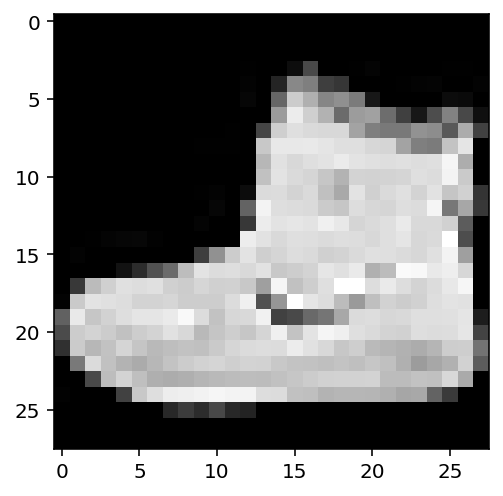

In [ ]:
# TODO 3.8. Get a sample from the dataset
sample = next(iter(dataset))

# TODO 3.9. Get the 28x28 image from the sample
image = sample[0]
print(type(image))
print(image.shape)

# TODO 3.10. Plot the image using cmap='gray'
plt.imshow(image.squeeze(), cmap="gray")

Great! Let's see more images using our dataloader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


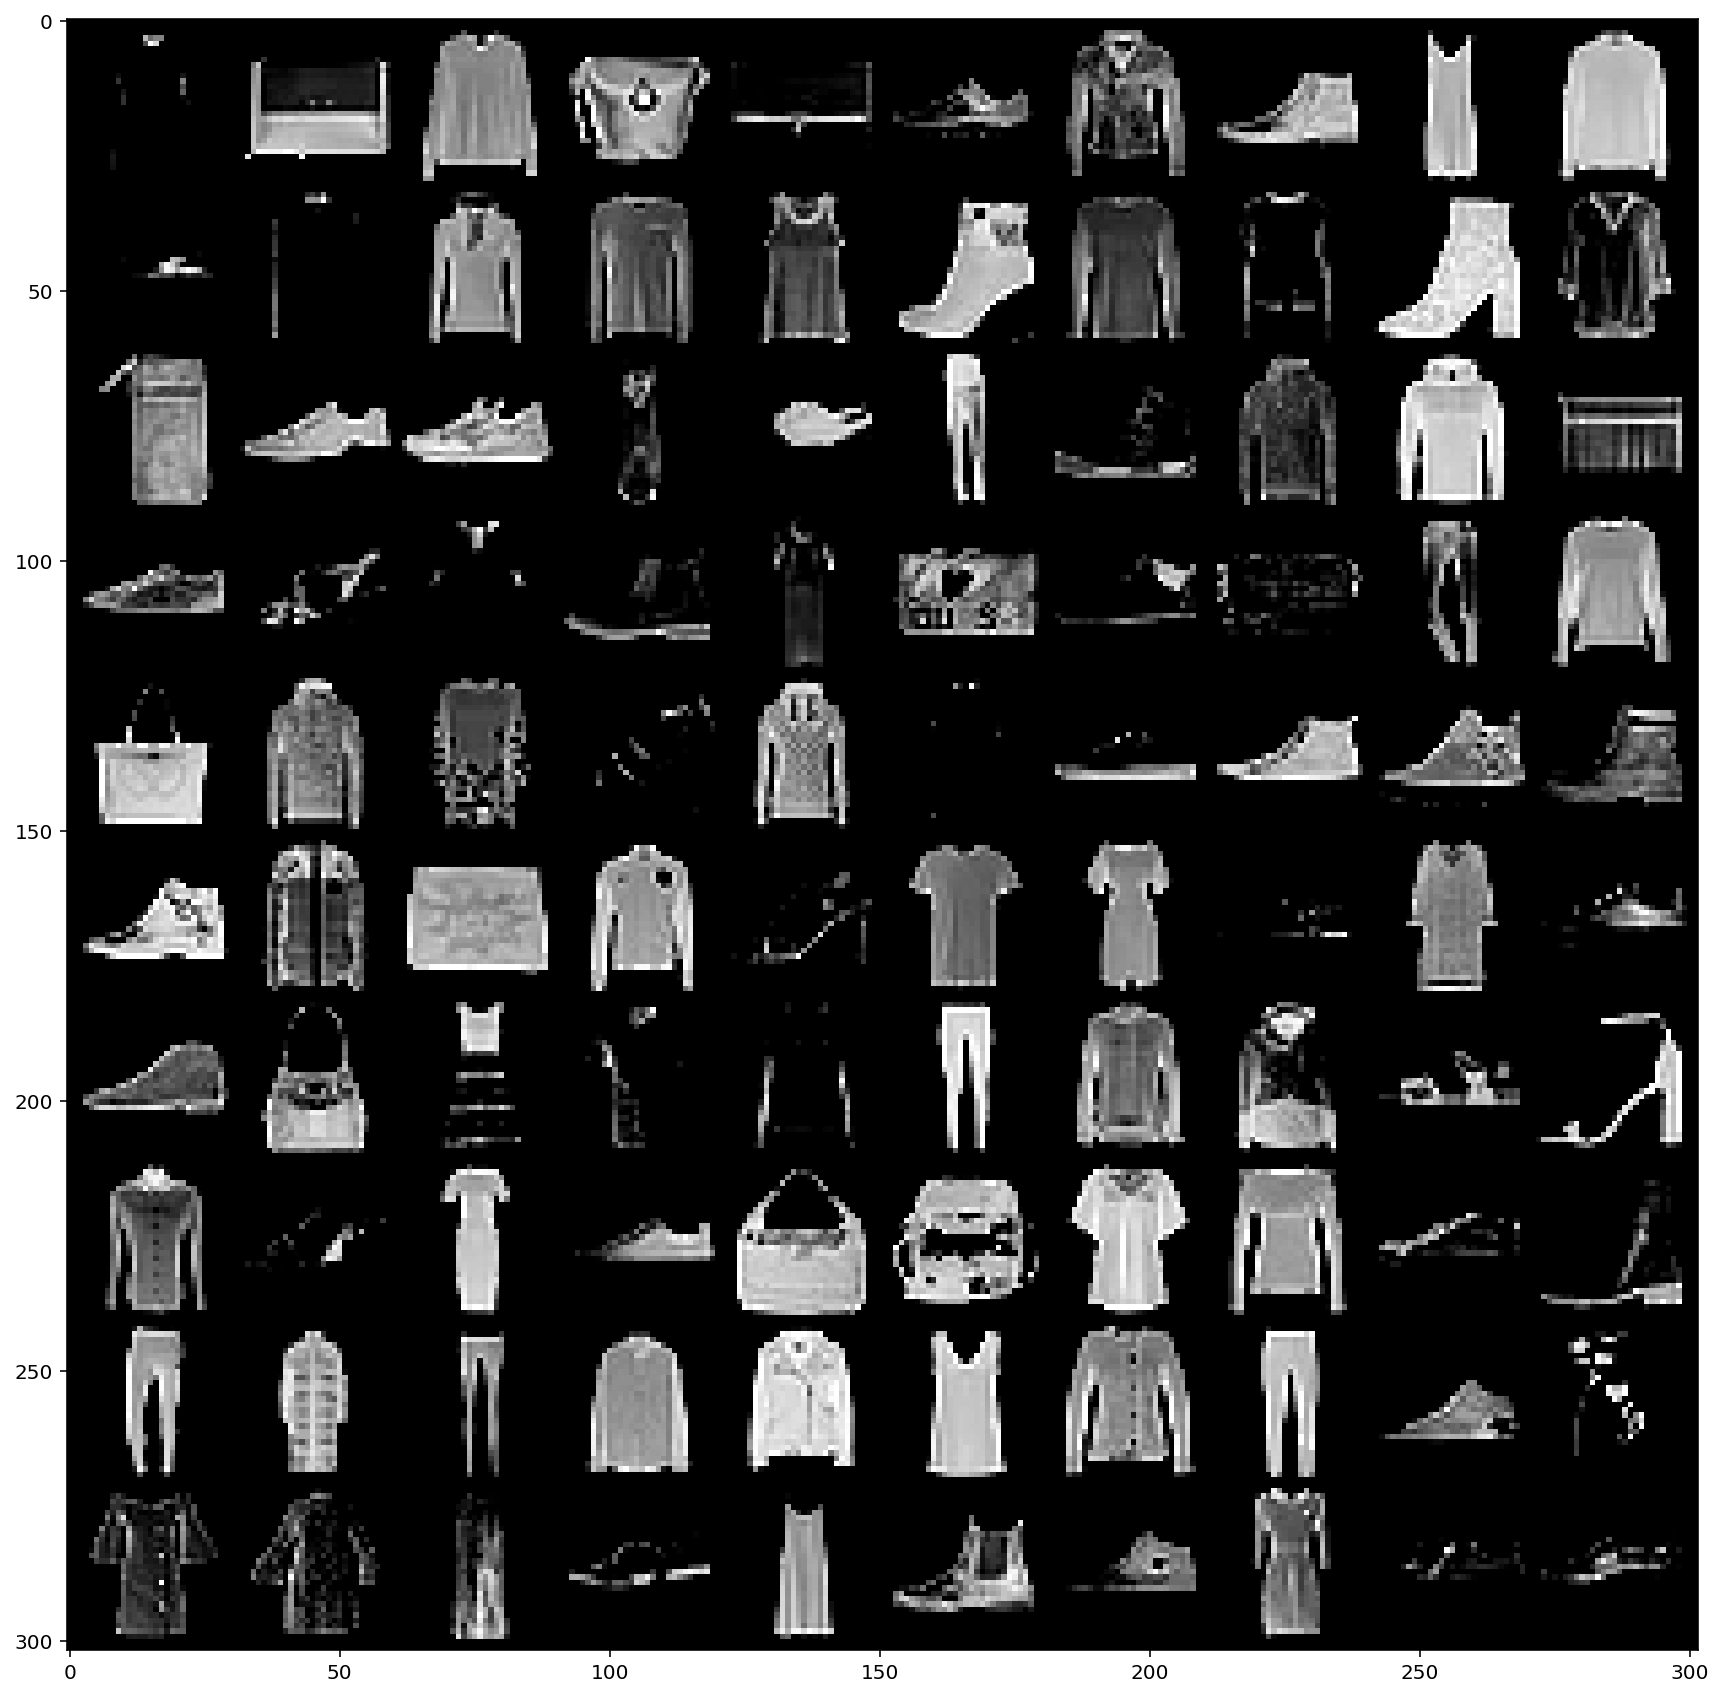

In [ ]:
# TODO 3.11. Get a batch of 28x28 images in a sample
images = next(iter(dataloader))[0]

# TODO 3.12. Create a grid of images
grid = torchvision.utils.make_grid(images, nrow = 10)

# TODO 3.13. Plot the grid of images
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))